## Network Biology 
### Coding Assignment 3
#### Submitted By: Divyanshu Srivastava

In [140]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from Bio.PDB import *
from IPython.display import HTML, display
import tabulate
from __future__ import division

#### Question 1


In [2]:
## Initialization

genes = 25
tfbs_pool = 10
tfbs_per_gene = 3

gene_pool = {}
for g in range(genes):
    gene_pool[g] = random.sample(range(tfbs_pool), tfbs_per_gene)

steps_of_evolution = 100

p_gene_dublication = 0.25
p_gene_deletion = 0.25
p_tfbs_dublication = 0.25
p_tfbs_deletion = 0.25
p_vector = [p_gene_dublication, p_gene_deletion, p_tfbs_dublication, p_tfbs_deletion]



## Evolution
for s in range(steps_of_evolution):
    r = np.random.choice(len(p_vector), p = p_vector)
#     print gene_pool
    if r == 0:
#         print "Evolution Step : " + str (s) + " Gene Dublication"
        gene_to_dublicate = random.sample(range(genes), 1)[0]
        gene_pool[genes] = copy.deepcopy(gene_pool[gene_to_dublicate])
        genes = genes + 1;
    elif r == 1:
#         print "Evolution Step : " + str (s) + " Gene Deletion"
        gene_to_delete = random.sample(range(genes), 1)[0]
#         gene_pool.pop(gene_to_delete)
        for i in range(gene_to_delete, genes-1):
            gene_pool[i] = copy.deepcopy(gene_pool[i+1])
#         if not gene_to_delete == genes - 1:
        gene_pool.pop(genes - 1)
        genes = genes-1
        if genes == 0:
            print "Gene Pool Empty !"
            break
    elif r == 2:
#         print "Evolution Step : " + str (s) + " TFBS Dublication"
        tfbs_probability = np.array(range(0, tfbs_pool))
        for g in gene_pool:
            for value in gene_pool[g]:
                tfbs_probability[value] = tfbs_probability[value]+1
        tfbs_probability = tfbs_probability.astype(np.float)
        tfbs_probability = tfbs_probability / np.sum(tfbs_probability)
        tfbs_to_dublicate = np.random.choice(tfbs_pool, p = tfbs_probability)
        flag = False
        while not flag:
            gene_target = np.random.choice(gene_pool.keys())
            if tfbs_to_dublicate not in gene_pool[gene_target]:
                gene_pool[gene_target].append(tfbs_to_dublicate)
                flag = True
    else:
#         print "Evolution Step : " + str (s) + " TFBS Deletion"
        gene_target = np.random.choice(gene_pool.keys())
#         print "gene_target = " + str(gene_target)
        tfbs_to_delete = np.random.choice(gene_pool[gene_target])
#         print "tfbs_to_delete = " + str(tfbs_to_delete)
        gene_pool[gene_target].remove(tfbs_to_delete)
#         print "gene pool agter deletion"
#         print gene_pool
        if len(gene_pool[gene_target]) == 0:
            
            gene_to_delete = gene_target
#             print "removing gene " + str(gene_to_delete)
#             gene_pool.pop(gene_to_delete)
            for i in range(gene_to_delete, genes-1):
#                 print i
                gene_pool[i] = copy.deepcopy(gene_pool[i+1])
#             if not gene_to_delete == genes - 1:
            gene_pool.pop(genes - 1)
            genes = genes-1
            if genes == 0:
                print "Gene Pool Empty !"
                break


                
## Building coevolution network
G = nx.Graph()
for g_a in gene_pool.keys():
    for g_b in gene_pool.keys():
        if not g_a == g_b: 
            if len(set(gene_pool[g_a]).intersection(gene_pool[g_b])) > 0:
                G.add_edge(g_a, g_b)
gene_pool


{0: [5, 9, 8, 7],
 1: [5, 3, 0],
 2: [4, 9, 2, 5, 7],
 3: [2, 7, 4, 5, 8],
 4: [9, 4],
 5: [4, 2, 6],
 6: [9, 8, 4],
 7: [4, 2, 6, 7, 5],
 8: [8, 4, 0],
 9: [9, 4, 5],
 10: [4, 5, 8, 9],
 11: [2, 5, 4],
 12: [9, 5, 3, 4],
 13: [4, 6, 7, 5, 9],
 14: [5, 9, 8, 7],
 15: [9, 4, 8],
 16: [5, 3, 0],
 17: [4, 9, 2, 5, 7]}

#### Question 2


In [3]:
def get_RIG(coordinates, labels, cut_off):
    """this function computes residue interaction graphs"""
    RIG = nx.Graph()
    label_ids = range(len(labels))
    RIG.add_nodes_from(label_ids)
    for i in label_ids:
        for j in label_ids:
            if not i == j:
                if np.linalg.norm(coordinates[i] - coordinates[j]) < 7:
                    RIG.add_edge(i, j)
    return RIG

def get_LIN(RIG, threshold):
    """this function computes long range network"""
    LIN = nx.Graph(RIG)
    for e in LIN.edges():
        if not abs(e[0] - e[1]) == 1:
            if abs(e[0] - e[1]) < threshold:
                LIN.remove_edge(e[0], e[1])
    return LIN

In [4]:
RIG_CUTOFF = 7
LIN_THRESHOLD = 12

parser = PDBParser()
pdb_files = ['1csp.pdb', '1hrc.pdb', '1pks.pdb', '2abd.pdb','3mef.pdb']
RIG = []
LIN = []


for pdb_file in pdb_files:
    structure = parser.get_structure('pdb_file', 'pdb files/' + pdb_file)
    coordinates = []
    labels = []
    for model in structure:
        for chain in model:
            for residue in chain:
                try:
                    coordinates.append(residue['CA'].get_coord())
                    labels.append(residue.get_resname())
                except KeyError:
                    pass
            RIG.append(get_RIG(coordinates, labels, RIG_CUTOFF))
            LIN.append(get_LIN(RIG[-1], LIN_THRESHOLD))
            break     ## working on chain id A only
        break         ## Working on model id 0 only
        
        
output = [['PBD ID', 'Nodes', 'Edges (RIG)', 'L (RIG)', 'C (RIG)', 'Edges (LIN)', 'L (LIN)', 'C (LIN)']]
for i in range(len(pdb_files)):
    append_list = [pdb_files[i], RIG[i].number_of_nodes(), RIG[i].number_of_edges()]
    append_list.append(nx.average_shortest_path_length(RIG[i]))
    append_list.append(nx.average_clustering(RIG[i]))
    append_list.append(LIN[i].number_of_edges())
    append_list.append(nx.average_shortest_path_length(LIN[i]))
    append_list.append(nx.average_clustering(LIN[i]))
    output.append(append_list)

display(HTML(tabulate.tabulate(output, tablefmt='html')))

PBD ID,Nodes,Edges (RIG),L (RIG),C (RIG),Edges (LIN),L (LIN),C (LIN)
1csp.pdb,67,255,3.0447761194,0.561993313486,146,4.61239258254,0.326143094054
1hrc.pdb,104,400,3.91486183719,0.566917484225,182,6.77445855116,0.227335164835
1pks.pdb,76,304,3.08070175439,0.557453657454,182,4.38877192982,0.332002354371
2abd.pdb,86,334,3.75923392613,0.57667093888,140,6.09083447332,0.125442967885
3mef.pdb,69,248,3.25532821824,0.574875527049,145,4.90707587383,0.289786059351


##### Observations
1csp and 1pks proteins show high cllustering coefficients in LIN models, suggesting that they have lower rate of foldings. 

#### Question 3


In [5]:
def get_Bartoli_RIG_Model(nodes, edges):
    """this function computes bartoli's model of residue interaction graphs"""
    Bartoli_RIG_Model = nx.Graph()
    Bartoli_RIG_Model.add_nodes_from(range(nodes))
    # adding backbone chain
    Bartoli_RIG_Model.add_path(range(nodes))
    # making other links
    d = {}      # dictionary key: absolute difference, values: possible pairs
    for i in range(nodes):
        for j in range(nodes):
            if abs(i-j) in d:
                d[abs(i-j)].append((i, j))
            else:
                d[abs(i-j)] = [(i, j)]
    del(d[0])        # not required
    del(d[1])        # already handled in backbone
    p = np.asarray([len(x) for x in d.values()]).astype(np.float)
    p = p/np.sum(p)
    while not nx.number_of_edges(Bartoli_RIG_Model) > edges:
        x = random.choice(d[np.random.choice(d.keys())])
    #     np.random.choice(d[np.random.choice(d.keys(), p)])
        Bartoli_RIG_Model.add_edge(x[0]-1, x[1]-1)
        Bartoli_RIG_Model.add_edge(x[0]-1, x[1])
        Bartoli_RIG_Model.add_edge(x[0]-1, x[1]+1)
        Bartoli_RIG_Model.add_edge(x[0], x[1]-1)
        Bartoli_RIG_Model.add_edge(x[0], x[1])
        Bartoli_RIG_Model.add_edge(x[0], x[1]+1)
        Bartoli_RIG_Model.add_edge(x[0]+1, x[1]-1)
        Bartoli_RIG_Model.add_edge(x[0]+1, x[1])
        Bartoli_RIG_Model.add_edge(x[0]+1, x[1]+1)
    return Bartoli_RIG_Model


In [6]:
## Bartoli's model for protein contact map models.

Bartoli_RIG_Model = []

for rig in RIG:
    nodes = nx.number_of_nodes(rig)
    edges = nx.number_of_edges(rig)
    Bartoli_RIG_Model.append(get_Bartoli_RIG_Model(nodes, edges))
    
    
output = [['PBD ID', 'Nodes', 'Edges (RIG)', 'L (RIG)', 'C (RIG)', 'Edges (Bartoli)', 'L (Bartoli)', 'C (Bartoli)']]
for i in range(len(pdb_files)):
    append_list = [pdb_files[i], RIG[i].number_of_nodes(), RIG[i].number_of_edges()]
    append_list.append(nx.average_shortest_path_length(RIG[i]))
    append_list.append(nx.average_clustering(RIG[i]))
    append_list.append(Bartoli_RIG_Model[i].number_of_edges())
    append_list.append(nx.average_shortest_path_length(Bartoli_RIG_Model[i]))
    append_list.append(nx.average_clustering(Bartoli_RIG_Model[i]))
    output.append(append_list)

display(HTML(tabulate.tabulate(output, tablefmt='html')))

PBD ID,Nodes,Edges (RIG),L (RIG),C (RIG),Edges (Bartoli),L (Bartoli),C (Bartoli)
1csp.pdb,67,255,3.0447761194,0.561993313486,258,2.89556692242,0.361318015602
1hrc.pdb,104,400,3.91486183719,0.566917484225,402,3.38526504942,0.35873664811
1pks.pdb,76,304,3.08070175439,0.557453657454,309,2.91774891775,0.412075838832
2abd.pdb,86,334,3.75923392613,0.57667093888,340,3.06217345873,0.361285212368
3mef.pdb,69,248,3.25532821824,0.574875527049,255,3.10890269151,0.400518053375


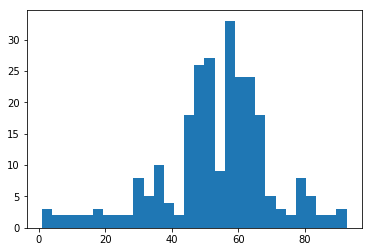

In [7]:
x = []
for e in Bartoli_RIG_Model[0].edges():
    x.append(np.linalg.norm(e))

plt.hist(x, bins = 30)
plt.show()

#### Question 4


ODD-ODD PIN
~~~~~~~~~~~

Nodes : 100
Edges : 3570
Sparseness : 0.286
Characteristic Path Length (L) : Graph is not connected.
Average Clustering Coefficient (C) : 0.85


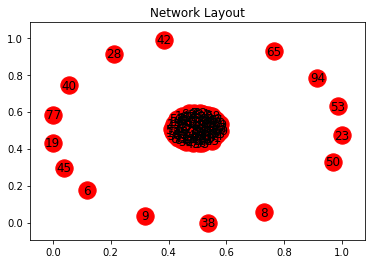

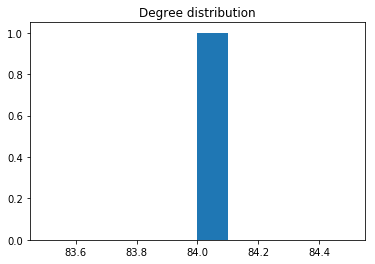

In [141]:
def display_graph(G):
    print "Nodes : " + str(G.number_of_nodes())
    print "Edges : " + str(G.number_of_edges())
    density = G.number_of_edges() / (G.number_of_nodes()*G.number_of_nodes()/2)
    print "Sparseness : " + str(1-density)
    try:
        print "Characteristic Path Length (L) : " + str(nx.average_shortest_path_length(G))
    except Exception as e:
        print "Characteristic Path Length (L) : " + str(e)       
    print "Average Clustering Coefficient (C) : " + str(nx.average_clustering(G))


    nx.draw_networkx(G)
    plt.title('Network Layout')
    plt.show()

    plt.hist(G.degree()[0])
    plt.title('Degree distribution')
    plt.show()


n_protein = 100
n_protein_domains = 50
domain_per_protein = 3
protein_domains = range(n_protein_domains)
protein = np.asmatrix([random.sample(range(n_protein_domains), domain_per_protein) for x in range(n_protein)])

G_odd_odd = nx.Graph()
G_odd_odd.add_nodes_from(range(n_protein))
for x in range(n_protein):
    for y in range(n_protein):
        if not x == y:
            if np.any(protein[x,] % 2) and np.any(protein[y,] % 2):
                G_odd_odd.add_edge(x, y)

print "ODD-ODD PIN"
print "~~~~~~~~~~~"
print ""
display_graph(G_odd_odd)

EVEN-EVEN PIN
~~~~~~~~~~~~~

Nodes : 100
Edges : 3655
Sparseness : 0.269
Characteristic Path Length (L) : Graph is not connected.
Average Clustering Coefficient (C) : 0.86


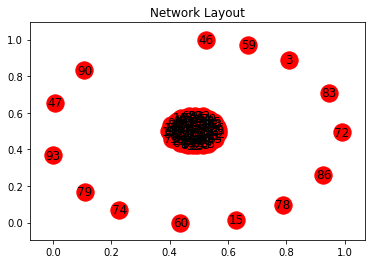

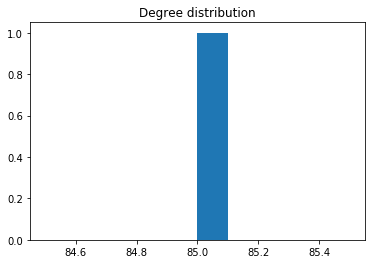

In [142]:
G_even_even = nx.Graph()
G_even_even.add_nodes_from(range(n_protein))
for x in range(n_protein):
    for y in range(n_protein):
        if not x == y:
            if not np.all(protein[x,] % 2) and not np.all(protein[y,] % 2):
                G_even_even.add_edge(x, y)

print "EVEN-EVEN PIN"
print "~~~~~~~~~~~~~"
print ""
display_graph(G_even_even)

ODD-EVEN PIN
~~~~~~~~~~~~~

Nodes : 100
Edges : 4754
Sparseness : 0.0492
Characteristic Path Length (L) : 1.0395959596
Average Clustering Coefficient (C) : 0.963467714076


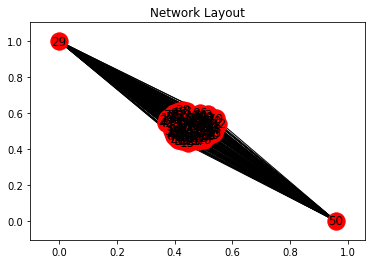

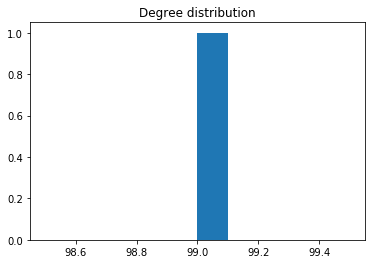

In [143]:
G_odd_even = nx.Graph()
G_odd_even.add_nodes_from(range(n_protein))
for x in range(n_protein):
    for y in range(n_protein):
        if not x == y:
            if (np.any(protein[x,] % 2) and not np.all(protein[y,] % 2)) or (not np.all(protein[x,] % 2) and np.any(protein[y,] % 2)):
                G_odd_even.add_edge(x, y)

print "ODD-EVEN PIN"
print "~~~~~~~~~~~~~"
print ""
display_graph(G_odd_even)

PRIME PRIME PIN
~~~~~~~~~~~~~~~

Nodes : 100
Edges : 2016
Sparseness : 0.5968
Characteristic Path Length (L) : Graph is not connected.
Average Clustering Coefficient (C) : 0.64


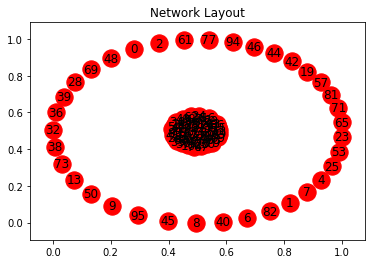

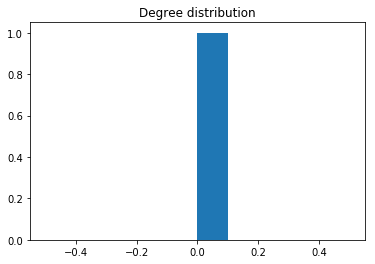

In [144]:
def is_prime(a):
    if a < 3:
        return False
    return all(a % i for i in xrange(2, a))

G_prime_prime = nx.Graph()
G_prime_prime.add_nodes_from(range(n_protein))
for x in range(n_protein):
    for y in range(n_protein):
        if not x == y:
            x_prime = []
            y_prime = []
            for z in range(domain_per_protein):
                x_prime.append(is_prime(protein[x, z]))
                y_prime.append(is_prime(protein[y, z]))
            if any(x_prime) and any(y_prime):
                G_prime_prime.add_edge(x, y)

print "PRIME PRIME PIN"
print "~~~~~~~~~~~~~~~"
print ""
display_graph(G_prime_prime)

In [131]:
print is_prime(-1)

True
